# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy


In [3]:
# Enter your information here
first_and_last_name = 'Keyhan Hodaei'
std_number = '401106696'

![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [4]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [6]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    x_normalized = (x-mean) / np.sqrt(variance+epsilon)
    return gamma*x_normalized + beta


In [7]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [8]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])




# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data
train_loader = DataLoader(Subset(train_set, range(len(train_set)//2)), batch_size=128, shuffle=False)


# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# TODO: create test
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)


100%|██████████| 170498071/170498071 [00:01<00:00, 95966097.51it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transform train and transform test:<br/>
In transform train we used RandomResizedCrop to crop the image to a random size and then resize it to 224x224. After that we used RandomHorizontalFlip to randomly flip the image horizontally. Then we used ToTensor to convert the image to PyTorch tensor. Finally, we used Normalize to normalize the image with the given mean and standard deviation.
In transform test we used Resize to resize the image to 224x224. Then we used ToTensor to convert the image to PyTorch tensor. Finally, we used Normalize to normalize the image with the given mean and standard deviation.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

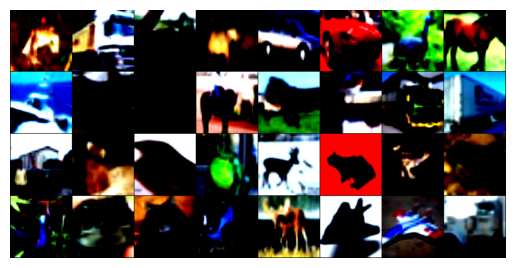

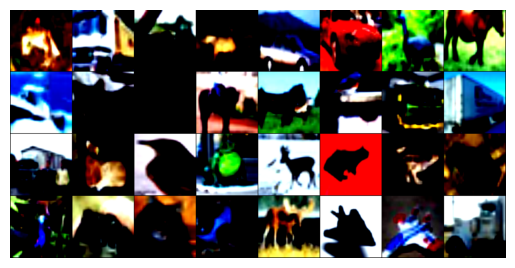

In [9]:
def imshow(img):
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# show some training images with shuffle=False and labels
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:32], nrow=8))

# show them again to check the augmentation
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:32], nrow=8))

# create train loader with shuffle true
train_dataloader = DataLoader(Subset(train_set, range(len(train_set)//2)), batch_size=128, shuffle=True)


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [10]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    total_loss = 0.0
    losses = []
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), disable=not train_mode)

    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        total_samples += labels.size(0)

        optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            _loss = criterion(outputs, labels)
            losses.append(_loss.item())
            total_loss += _loss.item()
            correct_predictions += (outputs.argmax(1) == labels).sum().item()

            if train_mode:
                _loss.backward()
                optimizer.step()

        progress_bar.set_description(f"Loss: {total_loss/(i+1):.4f}, Accuracy: {correct_predictions/total_samples:.4f}")

    return losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer, criterion = optim.Adam(model.parameters(), lr=lr), nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_losses.extend(fit_epoch(model, train_loader, criterion, optimizer, True))

        model.eval()
        with torch.no_grad():
            val_losses.extend(fit_epoch(model, val_loader, criterion, optimizer, False))

    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    correct, total = 0, 0
    model.eval()

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', alpha=.5)
    plt.plot(val_losses, label='Validation Loss', alpha=.5)
    plt.title('Losses')
    plt.legend()
    plt.show()


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [11]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU()
    )

def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv2d(in_channels=inp, out_channels=inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(),

        # Pointwise convolution
        nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU()
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


By using depthwise separable convolutions, the model reduces the number of parameters and computations required compared to traditional convolutions. This is achieved by splitting the convolution into two parts: depthwise convolution and pointwise convolution. Now we can calculate the number of parameters in each type of convolution and compare them:
\begin{equation}
\text{Depthwise Convolution Parameters} = \text{kernel size} \times \text{kernel size} \times \text{input channels}
\end{equation}
\begin{equation}
\text{Pointwise Convolution Parameters} = \text{input channels} \times \text{output channels}
\end{equation}  
\begin{equation}
\text{Total Parameters} = \text{Depthwise Convolution Parameters} + \text{Pointwise Convolution Parameters}
\end{equation}
Now we can compare the total number of parameters in a standard convolution and a depthwise separable convolution. Let's assume the kernel size is 3x3, the number of input channels is 64, and the number of output channels is 128 for this example.

Now please create your model.

In [12]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
            nn.Flatten(),
            nn.Linear(1024, n_class),
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        return self.model(x)

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [13]:
epochs = 10
lr = 1e-3
# TODO:
mobile_net_model = MobileNet(n_class=10).to(device)
train_losses, val_losses = train(train_dataloader, val_loader, mobile_net_model, epochs, lr)


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Get some metrics and plot your losses.

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.6778
Process validation time: 22.7630 s


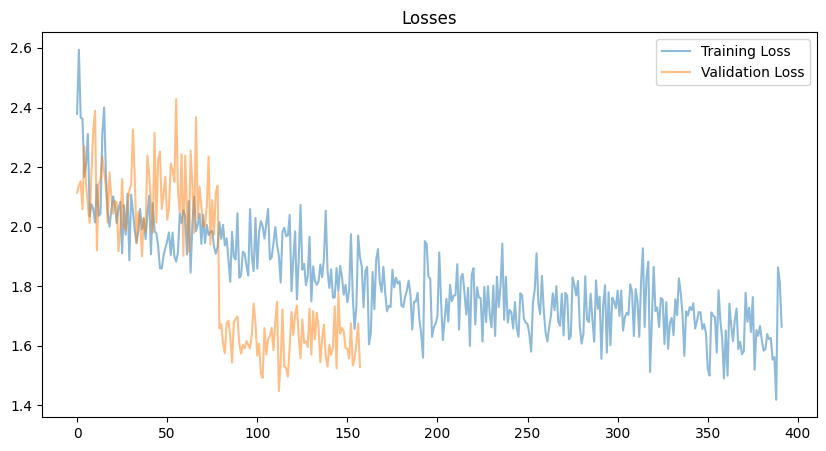

In [20]:
start = time.time()
val_acc = get_acc(mobile_net_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


MobileNet achieves an 8–9x speedup over standard convolution by replacing it with depthwise separable convolution, which splits the computation into two parts:
1. Depthwise Convolution: Applies a single kernel per input channel, requiring significantly fewer FLOPs.
2. Pointwise Convolution: Combines the output channels from the depthwise convolution using a 1x1 convolution.

The speedup is calculated using the ratio of FLOPs:
\begin{equation}
Speedup = \frac{C_{out} \times K^2}{K^2 + C_{out}}
\end{equation}
Where:
- $C_{out}$: Number of output channels.
- $K^2$: Number of FLOPs for a standard convolution.
- $K^2 + C_{out}$: Number of FLOPs for depthwise separable convolution.

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [15]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [16]:
# TODO: train model
epochs = 2
lr = 1e-3
normal_cnn_model = NormalCNN(n_class=10).to(device)
train_losses, val_losses = train(train_loader, val_loader, normal_cnn_model, epochs, lr)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.3852
Process validation time: 35.3399 s


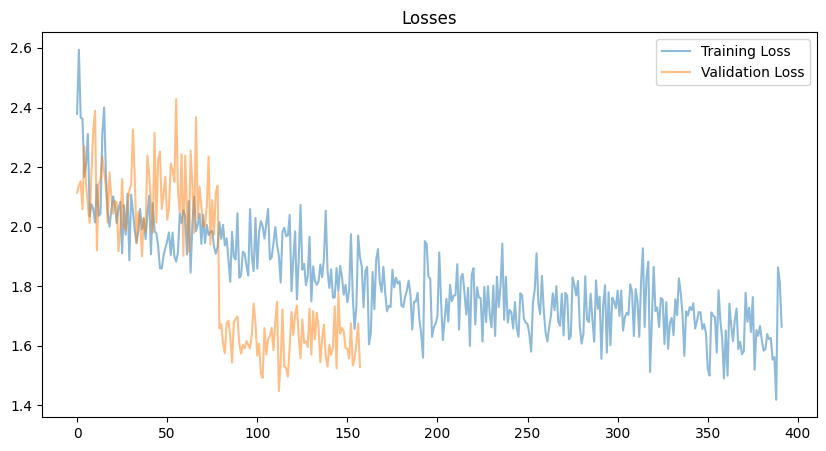

In [17]:
start = time.time()
val_acc = get_acc(normal_cnn_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

Normal CNN is slower than MobileNet.

In [18]:
# TODO: compare number of parameters in these two models
print('Total number of normal CNN parameters:', sum(param.numel() for param in normal_cnn_model.parameters()))
print('Total number of MobileNet parameters:', sum(param.numel() for param in mobile_net_model.parameters()))

Total number of normal CNN parameters: 28279338
Total number of MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [21]:
model = MobileNet(n_class=100).to(device)

#Todo:

# Load the pre-trained weights for the layers that match (excluding the final fc layer)
params = torch.load('/kaggle/input/input_models/pytorch/default/1/model.pt', weights_only=True)
model_dict = model.state_dict()

# Filter out unnecessary keys from the pretrained dict
params = {k: v for k, v in params.items() if k in model_dict and 'fc' not in k}


# Load the updated state dict into the model
model_dict.update(params)
model.load_state_dict(model_dict)


<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [22]:
# Freeze up to the desired layer (e.g., the first 7 layers)
for param in model.model[:8].parameters():
    param.requires_grad = False

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [28]:
# TRAIN DATA
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

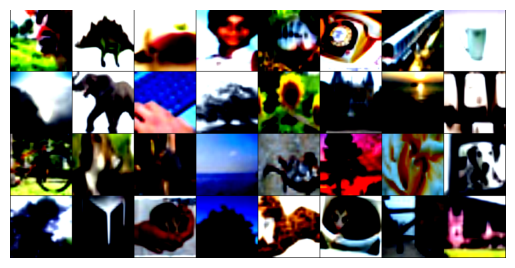

Labels are: tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17])


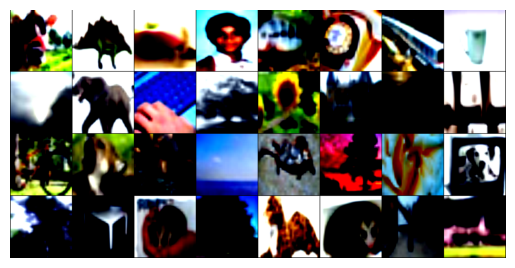

In [27]:
# show some training images with shuffle=False and labels
images, labels = next(iter(train_loader100))
imshow(torchvision.utils.make_grid(images[:32], nrow=8))

print('Labels are:', labels[:32])
# show them again to check the augmentation
images, labels = next(iter(train_loader100))
imshow(torchvision.utils.make_grid(images[:32], nrow=8))


Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)

Yes, CIFAR-10 and CIFAR-100 share the same images but differ in their labeling structure.

Now train your model using your functions.

In [29]:
epochs = 7
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Get some metrics and plot your losses.

Batch_size=128, epochs=7, lr=0.0002
Val accuracy = 0.281
Process validation time: 12.5800 s


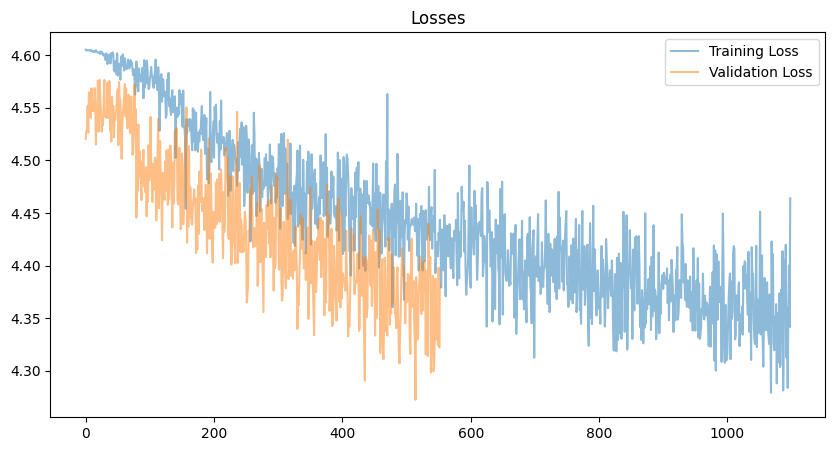

In [30]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

ReLU6 Activation Function is a variant of the ReLU activation function that clips the output at 6. This means that any value greater than 6 is set to 6. The ReLU6 activation function is commonly used in low-precision computations to prevent numerical instability and saturation. By limiting the output to a maximum value of 6, ReLU6 helps stabilize the training process and improve the model's performance, especially in mobile and embedded applications where low-precision arithmetic is used.

In [31]:

def conv_bn(inp, oup, stride):
    # Standard convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    # stride: stride for the convolution layer
    return nn.Sequential(
        nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6()
    )

def conv_1x1_bn(inp, oup):
    # 1x1 pointwise convolution followed by batch normalization and ReLU6 activation
    # inp: input channels
    # oup: output channels
    return nn.Sequential(
        nn.Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6()
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        # Inverted Residual block with optional skip connection
        # inp: input channels
        # oup: output channels
        # stride: stride for depthwise convolution
        # expand_ratio: multiplier for the hidden dimension size

        super().__init__()

        # Determine if a skip connection should be used
        # (only used when stride is 1 and input channels == output channels)
        self.skip_connection = stride == 1 and inp == oup




        # Calculate the number of hidden channels after expansion
        hidden_dim = int(inp * expand_ratio)


        # If expand_ratio is 1, skip the initial pointwise convolution
        if expand_ratio == 1:
            self.model = nn.Sequential(
                # Depthwise convolution
                nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(),

                # Pointwise-linear convolution
                nn.Conv2d(in_channels=hidden_dim, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
            )


        else:
            self.model = nn.Sequential(
                # Pointwise convolution to increase channel depth
                conv_1x1_bn(inp, hidden_dim),
                # Depthwise convolution
                nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(),
                # Pointwise-linear convolution to reduce channel depth
                nn.Conv2d(in_channels=hidden_dim, out_channels=oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        # Forward pass with optional residual connection
        if self.skip_connection:
            return x + self.model(x)
        return self.model(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [32]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super().__init__()
        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]



        # building first layer
        input_channel = int(32 * width_multiplier)
        self.layers = []
        self.layers.append(conv_bn(3, input_channel, 2))

        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.layers.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel


        # building last several layers
        output_channel = int(1280 * width_multiplier) if width_multiplier > 1. else 1280
        self.layers.append(conv_1x1_bn(input_channel, output_channel))
        self.layers.append(nn.AdaptiveAvgPool2d(1))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(output_channel, n_class))
        self.layers.append(nn.Softmax(dim=1))


        # building classifier
        self.model = nn.Sequential(*self.layers)



    def forward(self, x):
        return self.model(x)

How did you create linear bottlenecks? How do they help?


Linear bottlenecks are created by using 1x1 pointwise convolutions with no activation function between the depthwise and pointwise convolutions in inverted residual blocks. This helps maintain the information flow and reduces the risk of information loss by preserving low-dimensional representations. Linear bottlenecks are essential for MobileNetV2's efficiency and performance, as they allow the model to retain important features while minimizing the computational cost.

Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [33]:
model = MobileNetV2(n_class=10).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Get some metrics and plot your losses.

Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.0
Process validation time: 20.2507 s


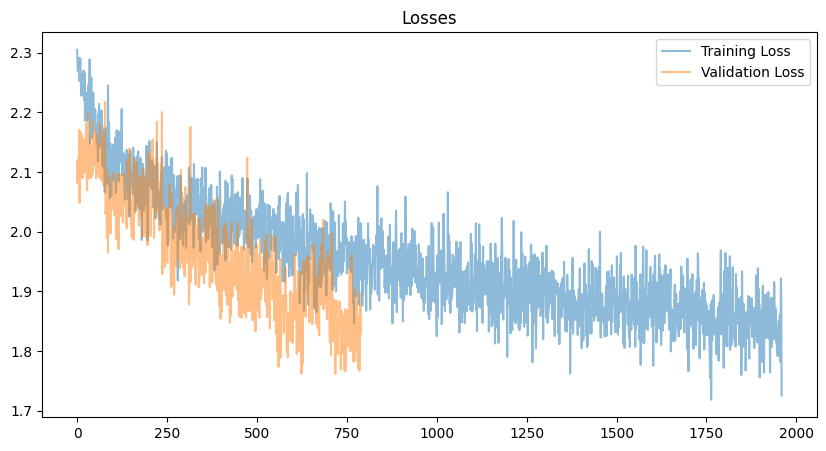

In [61]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [37]:
# TODO
width_multipliers = np.arange(.1, 1.1, .1)
for width_multiplier in width_multipliers:
    print(f'with {width_multiplier:.1f} width multiplier we got {sum(param.numel() for param in MobileNetV2(n_class=10, width_multiplier=width_multiplier).parameters())} parameters')

with 0.1 width multiplier we got 81943 parameters
with 0.2 width multiplier we got 183048 parameters
with 0.3 width multiplier we got 318444 parameters
with 0.4 width multiplier we got 487958 parameters
with 0.5 width multiplier we got 697258 parameters
with 0.6 width multiplier we got 931391 parameters
with 0.7 width multiplier we got 1203792 parameters
with 0.8 width multiplier we got 1510396 parameters
with 0.9 width multiplier we got 1851206 parameters
with 1.0 width multiplier we got 2236682 parameters


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [62]:
MNv2_path = '/kaggle/input/input_models/pytorch/default/1/MNv2WMmodel.pt'
# TODO
pretrained_model = MobileNetV2(n_class=10, width_multiplier=.5).to(device)
pretrained_model_dict = pretrained_model.state_dict()
loaded_dict = torch.load(MNv2_path)
for k1, k2 in zip(pretrained_model_dict, loaded_dict):
    pretrained_model_dict[k1] = loaded_dict[k2]
pretrained_model.load_state_dict(pretrained_model_dict)

/tmp/ipykernel_23/3013189596.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load(MNv2_path)


RuntimeError: Error(s) in loading state_dict for MobileNetV2:
	size mismatch for model.18.0.weight: copying a param with shape torch.Size([640, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([1280, 160, 1, 1]).
	size mismatch for model.18.1.weight: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for model.18.1.bias: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for model.18.1.running_mean: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for model.18.1.running_var: copying a param with shape torch.Size([640]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for model.21.weight: copying a param with shape torch.Size([10, 640]) from checkpoint, the shape in current model is torch.Size([10, 1280]).

In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))



  0%|          | 0/79 [00:00<?, ?it/s]

Val accuracy = 0.7432
Process validation time: 19.7670 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

This hyperparameter changes the number of parameters by scaling the number of output channels in each layer. The formula to predict the effect of the width multiplier on the number of parameters is:
\begin{equation}
\text{Number of Parameters} = \text{Base Parameters} \times \text{Width Multiplier}
\end{equation}
Where:
- Base Parameters: Total number of parameters in the base model without any scaling.
- Width Multiplier: Scaling factor for the number of output channels in each layer.
- Number of Parameters: Total number of parameters in the scaled model.
- For example, if the base model has 1 million parameters and the width multiplier is 0.5, the scaled model will have 0.5 million parameters.

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

The resolution multiplier does not directly affect the number of parameters in the model but can impact the model's speed and performance. By scaling the input resolution, the resolution multiplier can change the computational complexity of the model, making it faster or slower depending on the multiplier value. Lower resolution multipliers reduce the input size, leading to faster inference times but potentially lower accuracy. Higher resolution multipliers increase the input size, resulting in slower inference times but potentially higher accuracy. The resolution multiplier can be used to balance speed and accuracy based on the specific requirements of the application.

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

The number of parameters is important for several reasons:
- **Model Complexity**: More parameters can lead to increased model complexity, which may result in overfitting and reduced generalization performance.
- **Computational Cost**: Models with a large number of parameters require more computational resources (e.g., memory, processing power) to train and deploy.
- **Efficiency**: Smaller models with fewer parameters are more efficient and can be deployed on resource-constrained devices (e.g., mobile phones, IoT devices).
- **Interpretability**: Models with fewer parameters are often easier to interpret and analyze, leading to better understanding of the model's behavior.
- **Training Time**: Models with fewer parameters tend to train faster, reducing the time and resources required for training.
- While GPUs can significantly improve performance, reducing the number of parameters remains important for efficient training and maintenance of machine learning models. By optimizing the number of parameters, we can achieve a good balance between model complexity, performance, and efficiency.

## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [46]:
import timm

# Load a pre-trained ResNet18 fine-tuned on CIFAR-10
teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [47]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))


Val accuracy = 0.1017
Process validation time: 22.0843 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [54]:
class DistillationLoss(nn.Module):
    """
    Custom loss function for knowledge distillation combining KL divergence
    and cross-entropy loss.

    Args:
        temperature (float): Temperature parameter for scaling logits.
        alpha (float): Weighting factor for distillation and classification loss.
    """
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_divergence = nn.KLDivLoss(reduction='batchmean')

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        """
        Compute the combined distillation and classification loss.

        Args:
            student_logits (torch.Tensor): Logits from the student model.
            teacher_logits (torch.Tensor): Logits from the teacher model.
            labels (torch.Tensor): Ground truth labels.

        Returns:
            torch.Tensor: The computed loss value.
        """
        ce_loss = self.ce_loss(student_logits, labels)
        
        scaled_teacher_logits = teacher_logits / self.temperature
        scaled_student_logits = student_logits / self.temperature
        
        kl_loss = self.kl_divergence(
            F.log_softmax(scaled_student_logits, dim=1),
            F.softmax(scaled_teacher_logits, dim=1)
        )
        
        loss = self.alpha * ce_loss + (1 - self.alpha) * (self.temperature**2) * kl_loss
        return loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    """
    Train a student model using knowledge distillation.

    Args:
        teacher (nn.Module): Pre-trained teacher model.
        student (nn.Module): Student model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): Device to perform training on (CPU or GPU).
        epochs (int): Number of training epochs. Default is 10.
        lr (float): Learning rate for the optimizer. Default is 0.01.
    """
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs):
        student.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            student_logits = student(inputs)
            teacher_logits = teacher(inputs)

            loss = criterion(student_logits, teacher_logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        student.eval()
        with torch.no_grad():
            val_acc = get_acc(student, test_loader)

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.4f}')


Train it for one epoch to just check if it works.

In [56]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 1/1, Loss: 212.5962, Val Acc: 0.3864


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?


- **High Value of Alpha (e.g., 0.9)**:
  - **Pros**:
    - Emphasizes the distillation loss over the classification loss, leading to better alignment with the teacher's knowledge.
    - Encourages the student model to focus more on capturing the teacher's predictions and soft labels.
  - **Cons**:
    - May lead to overfitting to the teacher's knowledge, reducing the student model's ability to generalize to unseen data.
    - Could result in a loss of flexibility and adaptability in the student model.
- **Low Value of Alpha (e.g., 0.1)**:
    - **Pros**:
        - Emphasizes the classification loss over the distillation loss, allowing the student model to learn more from the ground truth labels.
        - Provides more flexibility for the student model to explore its own solutions.
    - **Cons**:
        - May result in the student model not fully capturing the teacher's knowledge and predictions.
        - Could lead to a slower convergence to the teacher's performance level.


## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018